In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

# 1. External Imports

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import setuptools.dist

from src import models

from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import torch
from torch_geometric.data import Data
from collections import OrderedDict
from torch_geometric.data import DataLoader

import math
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

# 2. Dataset loader

In [3]:
def load_dataset(encoding, fold, stratified, subset, path_prefix=''):

    base_path = os.getcwd() + path_prefix + '/../data/preprocessed/{type}/fold{no}_'.format(
        type = 'random' if not stratified else 'stratified',
        no = fold
    )

    x_paths = base_path + '{encoding}' + '_{set}{subset}.npz'
    y_paths = base_path + '{set}{subset}.npz'

    subset = ('_' + subset) if subset is not None else ''

    y_train = y_paths.format(set = 'y_train', subset = subset)
    smiles_train = y_paths.format(set = 'smiles_train', subset = subset)

    x_train = x_paths.format(encoding=encoding, set = 'x_train', subset = subset)

    if encoding == 'smiles':
        x_train = smiles_train

    x_train_load = np.load(x_train, allow_pickle=True)
    x_train_load = [x_train_load[f] for f in x_train_load.files]

    if len(x_train_load) == 1:
        x_train_load = x_train_load[0]


    y_test = y_paths.format(set = 'y_test', subset = subset)
    smiles_test = y_paths.format(set = 'smiles_test', subset = subset)

    x_test = x_paths.format(encoding=encoding, set = 'x_test', subset = subset)
    
    if encoding == 'smiles':
        x_test = smiles_test
        
    x_test_load = np.load(x_test, allow_pickle=True)
    x_test_load = [x_test_load[f] for f in x_test_load.files]

    if len(x_test_load) == 1:
        x_test_load = x_test_load[0]

    train = (x_train_load, np.load(y_train, allow_pickle=True)['y'], np.load(smiles_train, allow_pickle=True)['smiles'])
    test = (x_test_load, np.load(y_test, allow_pickle=True)['y'], np.load(smiles_test, allow_pickle=True)['smiles'])
    return print(x_train)
    return (train, test)

# Graph NN

In [4]:

possible_atom_list = ['S', 'Si', 'F', 'O',
                      'C', 'I', 'P', 'Cl', 'Br', 'N', 'Unknown']

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_features(atom):
    results = one_of_k_encoding_unk(atom.GetSymbol(), possible_atom_list) + \
        one_of_k_encoding(atom.GetDegree(),
                          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + \
        one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
        [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
        one_of_k_encoding_unk(atom.GetHybridization(), [
            Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
            SP3D, Chem.rdchem.HybridizationType.SP3D2
        ]) + [atom.GetIsAromatic()]
    return np.array(results).astype(np.float32)


def bond_features(bond):
    bt = bond.GetBondType()
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()]
    return np.array(bond_feats).astype(np.float32)


def n_atom_features():
    atom = Chem.MolFromSmiles('C').GetAtomWithIdx(0)
    return len(atom_features(atom))


def n_bond_features():
    bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
    return len(bond_features(bond))

## Molan model GCN

In [5]:
def net_pattern(n_layers, base_size, ratio, maxv=1024):
    return [int(min(max(math.ceil(base_size * (ratio**i)), 0), maxv)) for i in range(0, n_layers)]

def make_mlp(start_dim, n_layers, ratio, act, batchnorm, dropout):
    layer_sizes = net_pattern(n_layers + 1, start_dim, ratio)
    layers = []
    for index in range(n_layers):
        layers.append(nn.Linear(layer_sizes[index], layer_sizes[index + 1]))
        layers.append(str2act(act))
        if batchnorm:
            layers.append(nn.BatchNorm1d(layer_sizes[index + 1]))
        if dropout > 0.0:
            layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers), layer_sizes[-1]

def str2act(act):
    activations = {'relu': nn.ReLU(), 'selu': nn.SELU(), 'celu': nn.CELU(
    ), 'softplus': nn.Softplus(), 'softmax': nn.Softmax(), 'sigmoid': nn.Sigmoid()}
    return activations[act]

def str2funct_act(act):
    activations = {'relu': F.relu, 'selu': F.selu, 'celu': F.celu,
                   'softplus': F.softplus, 'softmax': F.softmax, 'sigmoid': F.sigmoid}
    return activations[act]

class molan_model_GCN(torch.nn.Module):
    def __init__(self, hparams, node_dim, edge_dim):
        super(molan_model_GCN, self).__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.hparams = hparams
        self.output_dim = 1

        # Linear atom embedding
        self.linatoms = torch.nn.Linear(
            self.node_dim, hparams['conv_base_size'])

        # Graph Convolution
        emb_dim = hparams['emb_dim']
        conv_dims = net_pattern(hparams['conv_n_layers'],
                                hparams['conv_base_size'],
                                hparams['conv_ratio']) + [emb_dim]
        conv_layers = []
        for index in range(hparams['conv_n_layers']):
            conv_layers.append(gnn.GCNConv(
                conv_dims[index], conv_dims[index + 1], cached=False))

        self.graph_conv = nn.ModuleList(conv_layers)
        if self.hparams['conv_batchnorm']:
            self.bn = nn.ModuleList([nn.BatchNorm1d(dim)
                                     for dim in conv_dims[1:]])
        # Graph embedding
        if hparams['emb_set2set']:
            self.graph_emb = gnn.Set2Set(emb_dim, processing_steps=3)
            emb_dim = emb_dim * 2
        else:
            self.graph_emb = nn.Sequential(nn.Linear(emb_dim, emb_dim),
                                           str2act(hparams['emb_act']))

        # Build mlp
        self.using_mlp = hparams['mlp_layers'] > 0
        if self.using_mlp:
            self.mlp, last_dim = make_mlp(emb_dim,
                                          hparams['mlp_layers'],
                                          hparams['mlp_dim_ratio'],
                                          hparams['mlp_act'],
                                          hparams['mlp_batchnorm'],
                                          hparams['mlp_dropout'])
        else:
            last_dim = emb_dim

        # Prediction
        self.pred = nn.Linear(last_dim, self.output_dim)

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, data):
        x, edge_index = data.x, data.edge_index
        # Linear atom embedding
        x = self.linatoms(x)
        # GCN part
        for index in range(self.hparams['conv_n_layers']):
            x = self.graph_conv[index](x, edge_index)
            x = str2funct_act(self.hparams['conv_act'])(x)
        return x

    def forward_gnn(self, data, gradcam=False):
        x, edge_index = data.x, data.edge_index
        # Linear atom embedding
        x = self.linatoms(x)
        # GCN part
        for index in range(self.hparams['conv_n_layers']):
            x = self.graph_conv[index](x, edge_index)
            x = str2funct_act(self.hparams['conv_act'])(x)
            if gradcam and index == self.hparams['conv_n_layers'] - 1:
                # register the hook
                x.register_hook(self.activations_hook)

            if self.hparams['conv_batchnorm']:
                x = self.bn[index](x)

        # Graph embedding
        if self.hparams['emb_set2set']:
            x = self.graph_emb(x, data.batch)
        else:
            x = self.graph_emb(x)
            x = gnn.global_add_pool(x, data.batch)
        # NNet
        if self.using_mlp:
            x = self.mlp(x)
        return x

    def forward(self, data, gradcam=False):
        x = self.forward_gnn(data, gradcam)
        # Prediction
        x = self.pred(x)
        return x.view(-1)


# GCN Model setup

In [6]:
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[], []]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

def mol2torchdata(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f = [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond) for bond in bonds]
    for bond in bonds:
        edge_attr.append(bond_features(bond))
    data = Data(x=torch.tensor(node_f, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr, dtype=torch.float)
                )
    return data

class GCN:
    # Some code here taken directly from MOLAN
    seed = 9700
    conv_n_layers = 5
    conv_base_size = 64
    conv_ratio = 1.25
    conv_batchnorm = True
    conv_act = 'relu'
    emb_dim = 100
    emb_set2set = False
    emb_act = 'softmax'
    mlp_layers = 2
    mlp_dim_ratio = 0.5
    mlp_dropout = 0.15306049825909776
    mlp_act = 'relu'
    mlp_batchnorm = True
    residual = False
    learning_rate = 0.008117123009364938
    batch_size = 64
    epochs = 500
    node_dim = n_atom_features()
    edge_dim = n_bond_features()

    def fit(self, x_train, y_train):
        torch.manual_seed(self.seed)

        hparams = OrderedDict([('conv_n_layers', self.conv_n_layers), ('conv_base_size', self.conv_base_size),
                        ('conv_ratio', self.conv_ratio), ('conv_batchnorm', self.conv_batchnorm),
                        ('conv_act', self.conv_act), ('emb_dim', self.emb_dim),
                        ('emb_set2set', self.emb_set2set), ('emb_act', self.emb_act),
                        ('mlp_layers', self.mlp_layers), ('mlp_dim_ratio', self.mlp_dim_ratio),
                        ('mlp_dropout', self.mlp_dropout), ('mlp_act', self.mlp_act),
                        ('mlp_batchnorm', self.mlp_batchnorm), ('residual', self.residual)])

        hparams['lr'] = self.learning_rate
        hparams['batch_size'] = self.batch_size
        hparams['model'] = 'GCN'

        x_train = [mol2torchdata(Chem.MolFromSmiles(smile)) for smile in x_train.flatten()]

        for data, y in zip(x_train, y_train):
            data.y = torch.tensor(y, dtype=torch.float)

        loader = DataLoader(x_train, batch_size=self.batch_size,
            shuffle=False, drop_last=True)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = molan_model_GCN(hparams, self.node_dim, self.edge_dim).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams['lr'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                        mode = 'min',
                        factor = 0.5,
                        patience = 20,
                        verbose = True)

        for i in range(self.epochs):
            print('Step %d/%d' % (i+1, self.epochs))
            training.train_step(self.model, loader, optimizer, scheduler, self.device)

    def predict(self, x_in):
        # should drop_last=False
        x_in = [mol2torchdata(Chem.MolFromSmiles(smile)) for smile in x_in.flatten()]

        loader = DataLoader(x_in, batch_size=1,
            shuffle=False, drop_last=False)

        results = []

        with torch.no_grad():
            self.model.eval()
            
            for data in loader:
                data = data.to(self.device)
                output = self.model(data)
                results.extend(output.cpu().numpy())

        return np.array(results).reshape(-1,1)

    def save_weights(self, fn):
        torch.save(self.model.state_dict(), fn)

    def load_weights(self, fn):
        hparams = OrderedDict([('conv_n_layers', self.conv_n_layers), ('conv_base_size', self.conv_base_size),
                        ('conv_ratio', self.conv_ratio), ('conv_batchnorm', self.conv_batchnorm),
                        ('conv_act', self.conv_act), ('emb_dim', self.emb_dim),
                        ('emb_set2set', self.emb_set2set), ('emb_act', self.emb_act),
                        ('mlp_layers', self.mlp_layers), ('mlp_dim_ratio', self.mlp_dim_ratio),
                        ('mlp_dropout', self.mlp_dropout), ('mlp_act', self.mlp_act),
                        ('mlp_batchnorm', self.mlp_batchnorm), ('residual', self.residual)])

        hparams['lr'] = self.learning_rate
        hparams['batch_size'] = self.batch_size
        hparams['model'] = 'GCN'

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = molan_model_GCN(hparams, self.node_dim, self.edge_dim)
        self.model.load_state_dict(torch.load(fn))

# Experimental setup

In [7]:
scaler = StandardScaler()

class LD50UnitConverter():
    def convert_to_mgkg(self, neglogld50s, smiles):

        for neglogld50, smile in zip(neglogld50s, smiles):
            molwt = Descriptors.MolWt(Chem.MolFromSmiles(smile[0]))
            yield (10**(-1*neglogld50[0]))*1000*molwt


    def convert_to_epa(self, neglogld50s, smiles):
        mgkg = list(self.convert_to_mgkg(neglogld50s=neglogld50s, smiles=smiles))

        return pd.cut(mgkg, labels=(0,1,2,3), bins=(-np.inf,50,500,5000, np.inf))

class CrossValidator():
    def __init__(self, splits = 5, sampling_type = 'random'):
        self.sampling_stratified = sampling_type == 'stratified'
        self.splits = splits

    def get_folds(self, encoding, subset = None):
       for fold in range(self.splits):
            yield load_dataset(encoding, fold, stratified=self.sampling_stratified, subset=subset,
                path_prefix = '/../')
            
_benchmarks = {
    'gcn': {'model': models.GCN, 'encoding': 'smiles'}
}

# `random` or `stratified`
sampling_type = 'random'

kfold = CrossValidator(
    splits = 5, # dont change without re-running data preprocessing
    sampling_type = sampling_type,
)

converter = LD50UnitConverter()

# Train/predict using benchmark models

In [8]:
benchmark = _benchmarks['gcn']

folds = enumerate(kfold.get_folds(benchmark['encoding']))

all_results = []

for fold_no, (train, test) in folds:           
    x_train, y_train, smiles_train = train
    x_test, y_test, smiles_test = test
    
    y_train = scaler.fit_transform(y_train)
    
    model = _benchmarks['gcn']['model']()
        
    model.fit(x_train, y_train)
    
    #save model
    fn = 'gcn' + str(fold_no) + '_' + sampling_type
    model.save_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
    
    y_hat = scaler.inverse_transform(model.predict(x_test))
    
    results = pd.DataFrame({
        'smiles': smiles_test.flatten(),
        'prediction_neglogld50': y_hat.flatten(),
        'prediction_mgkg': converter.convert_to_mgkg(y_hat, smiles_test),
        'prediction_epa': converter.convert_to_epa(y_hat, smiles_test),
        'actual_neglogld50': y_test.flatten(),
        'actual_mgkg': converter.convert_to_mgkg(y_test, smiles_test),
        'actual_epa': converter.convert_to_epa(y_test, smiles_test),
    })
    
    results.to_csv('../../data/benchmark-models/%s_predictions.csv' % fn)
    all_results.append(results)

c:\Users\xalvna\Desktop\Natalia\master\courses\Project course\AI4PFAS_replication_2024\notebooks\gcn/..//../data/preprocessed/random/fold0_smiles_train.npz


TypeError: cannot unpack non-iterable NoneType object

# Results comparison

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error

def variance_of_residuals(y_true, y_predicted):
    # Calculate the residuals (errors)
    residuals = np.array(y_true) - np.array(y_predicted)
    
    # Compute the variance using the formula for variance
    mean_residual = np.mean(residuals)
    return np.mean((residuals - mean_residual) ** 2)

compare_benchmarks = ['gcn'] 

aggregated = pd.DataFrame()
all_results_2 = []

for identity in compare_benchmarks:
    benchmark = _benchmarks[identity]
    
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, data in folds:
        fn = identity + str(fold_no) + '_' + sampling_type
        
        validation = pd.read_csv('../../data/benchmark-models/%s_predictions.csv' % fn)
        all_results_2.append(validation)
        
        # Create a temporary DataFrame for the new row
        temp_df = pd.DataFrame([{
            'benchmark': identity,
            'r2': r2_score(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'mae': mean_absolute_error(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'variance': variance_of_residuals(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'rmse': root_mean_squared_error(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'accuracy': np.sum(validation['actual_epa'] == validation['prediction_epa']) / len(validation)
        }])

        # Concatenate the temporary DataFrame with the aggregated DataFrame
        aggregated = pd.concat([aggregated, temp_df], ignore_index=True)


In [ ]:
aggregated.pivot_table(index='benchmark', aggfunc=np.mean)

C:\Users\xalvna\AppData\Local\Temp\ipykernel_21564\3530873064.py:1: FutureWarning: The provided callable <function mean at 0x00000218DA9A2200> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  aggregated.pivot_table(index='benchmark', aggfunc=np.mean)


,accuracy,mae,r2,rmse,variance
benchmark,,,,,
gcn,0.575661,0.468419,0.453306,0.651519,0.393971


In [ ]:
def convert_to_mgkg(neglogld50s, smiles):
    mgkg_values = []
    for neglogld50, smile in zip(neglogld50s, smiles):
        molwt = Descriptors.MolWt(Chem.MolFromSmiles(smile))
        mgkg = (10**(-1*neglogld50)) * 1000 * molwt
        mgkg_values.append(mgkg)
    return mgkg_values

# Function to convert mg/kg values to EPA categories
def convert_to_epa(neglog_values, smiles):
    mgkg_values = convert_to_mgkg(neglog_values, smiles)
    epa_categories = pd.cut(mgkg_values, labels=[0,1,2,3], bins=[-np.inf, 50, 500, 5000, np.inf])
    return epa_categories

In [ ]:
concatenated_df = pd.concat(all_results_2, ignore_index=True)

epa_columns = concatenated_df.filter(like='epa').columns  
neglog_columns = concatenated_df.filter(like='neglogld50').columns

grouped_df = concatenated_df.groupby('smiles').agg(
    {**{col: 'mean' for col in neglog_columns},  # Mean for neglog columns
     **{col: lambda x: x.mode()[0] if not x.mode().empty else None for col in epa_columns}}  # Mode for EPA columns
).reset_index()

grouped_df['prediction_epa_from_neglog'] = convert_to_epa(grouped_df['prediction_neglogld50'], smiles=grouped_df['smiles'])

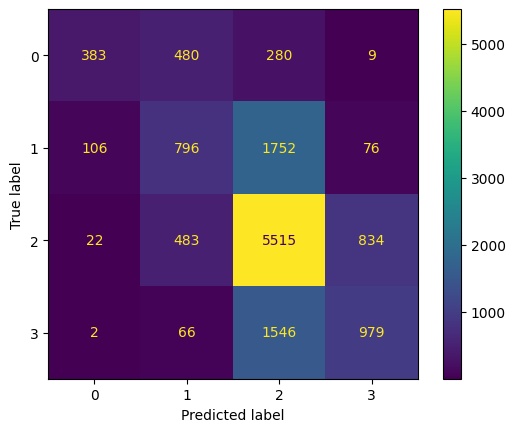

In [ ]:
ConfusionMatrixDisplay.from_predictions(grouped_df['actual_epa'], grouped_df['prediction_epa'])
plt.show()

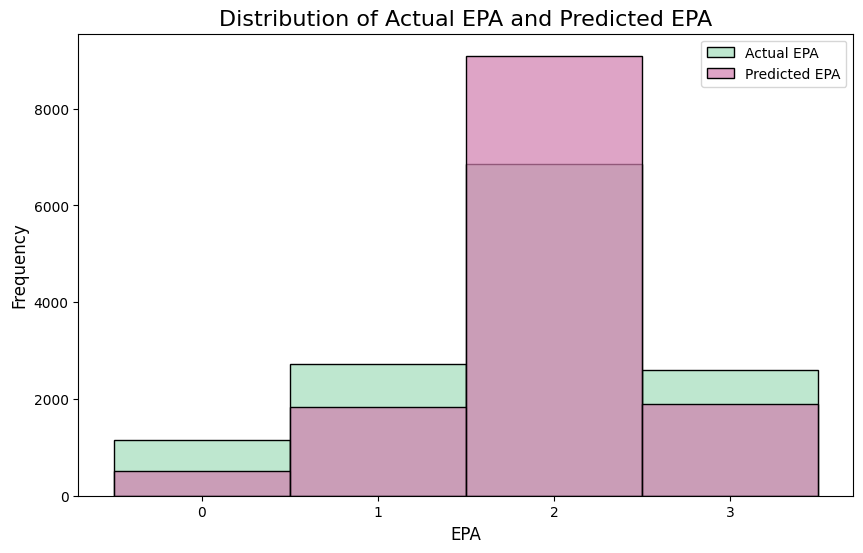

In [ ]:
# Missclassified
plt.figure(figsize=(10, 6))

# bins
bins = np.arange(grouped_df['actual_epa'].min() - 0.5, grouped_df['actual_epa'].max() + 1.5, 1)

# Plot 'actual_epa'
sns.histplot(grouped_df['actual_epa'], color='#7ed0a0', label='Actual EPA', kde=False, alpha=0.5, bins=bins)

# Plot the d'predicted_epa'
sns.histplot(grouped_df['prediction_epa'], color='#d07eae', label='Predicted EPA', kde=False, alpha=0.7, bins=bins)

# Add labels and title
plt.title('Distribution of Actual EPA and Predicted EPA', fontsize=16)
plt.xlabel('EPA', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add legend
plt.legend()
# Ensure x-axis ticks are integers
plt.xticks(np.arange(grouped_df['actual_epa'].min(), grouped_df['actual_epa'].max() + 1, 1))

# Show the plot
plt.show()


In [ ]:
full_data = pd.read_csv('../../data/full_dataset.csv')
grouped_df = grouped_df.merge(full_data, how='left', left_on=['smiles'], right_on=['SMI'])

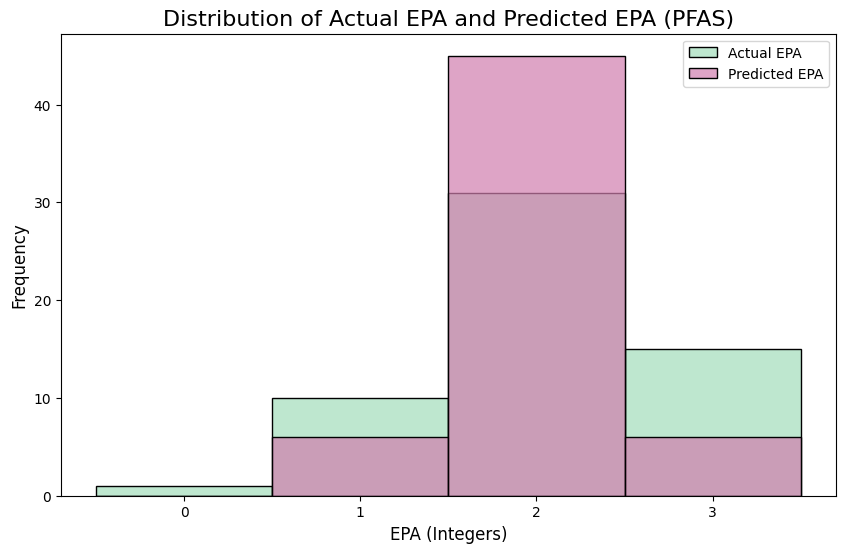

In [ ]:
# Filter the DataFrame to include only rows where is_pfas is True
df_pfas = grouped_df[grouped_df['is_pfas'] == True]

# Set the figure size for better clarity
plt.figure(figsize=(10, 6))

bins = np.arange(df_pfas['actual_epa'].min() - 0.5, df_pfas['actual_epa'].max() + 1.5, 1)
sns.histplot(df_pfas['actual_epa'], color='#7ed0a0', label='Actual EPA', kde=False, alpha=0.5, bins=bins)
sns.histplot(df_pfas['prediction_epa'], color='#d07eae', label='Predicted EPA', kde=False, alpha=0.7, bins=bins)

# Add labels and title
plt.title('Distribution of Actual EPA and Predicted EPA (PFAS)', fontsize=16)
plt.xlabel('EPA (Integers)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Ensure x-axis ticks are integers
plt.xticks(np.arange(df_pfas['actual_epa'].min(), df_pfas['actual_epa'].max() + 1, 1))

# Add legend
plt.legend()

# Show the plot
plt.show()

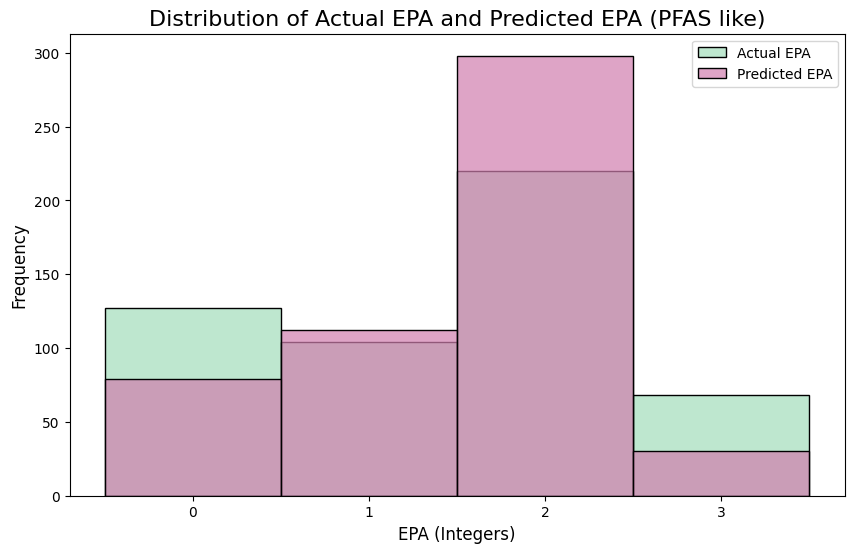

In [ ]:
# Filter the DataFrame to include only rows where is_pfas_like is True
df_pfas_like = grouped_df[grouped_df['is_pfas_like'] == True]

# Set the figure size for better clarity
plt.figure(figsize=(10, 6))

bins = np.arange(df_pfas_like['actual_epa'].min() - 0.5, df_pfas['actual_epa'].max() + 1.5, 1)
sns.histplot(df_pfas_like['actual_epa'], color='#7ed0a0', label='Actual EPA', kde=False, alpha=0.5, bins=bins)
sns.histplot(df_pfas_like['prediction_epa'], color='#d07eae', label='Predicted EPA', kde=False, alpha=0.7, bins=bins)

# Add labels and title
plt.title('Distribution of Actual EPA and Predicted EPA (PFAS like)', fontsize=16)
plt.xlabel('EPA (Integers)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Ensure x-axis ticks are integers
plt.xticks(np.arange(df_pfas_like['actual_epa'].min(), df_pfas['actual_epa'].max() + 1, 1))

# Add legend
plt.legend()

# Show the plot
plt.show()

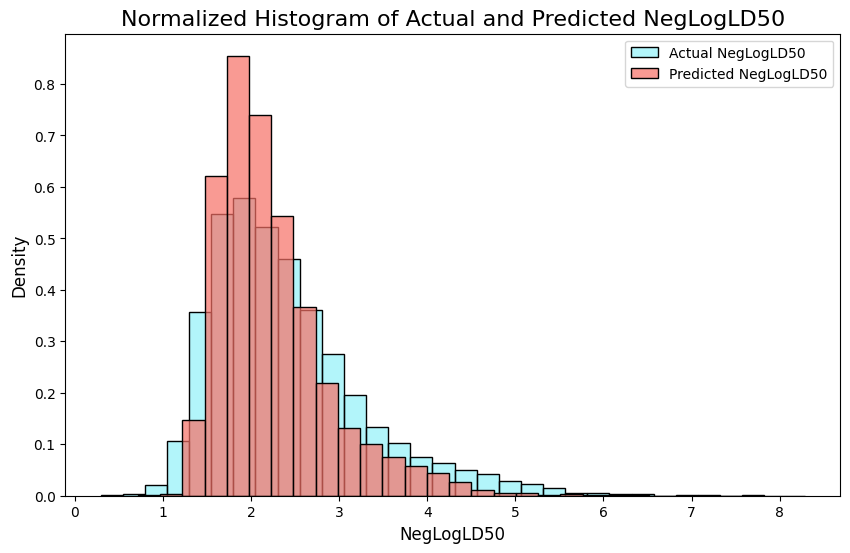

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the normalized histogram of 'actual_neglogld50'
sns.histplot(grouped_df['actual_neglogld50'], color='#66edf7', label='Actual NegLogLD50', kde=False, stat='density', alpha=0.5, bins=30)

# Plot the normalized histogram of 'prediction_neglogld50' with bars in front of 'actual_neglogld50'
sns.histplot(grouped_df['prediction_neglogld50'], color='#f77066', label='Predicted NegLogLD50', kde=False, stat='density', alpha=0.7, bins=30)

# Add labels and title
plt.title('Normalized Histogram of Actual and Predicted NegLogLD50', fontsize=16)
plt.xlabel('NegLogLD50', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add legend
plt.legend()

# Show the plot
plt.show()

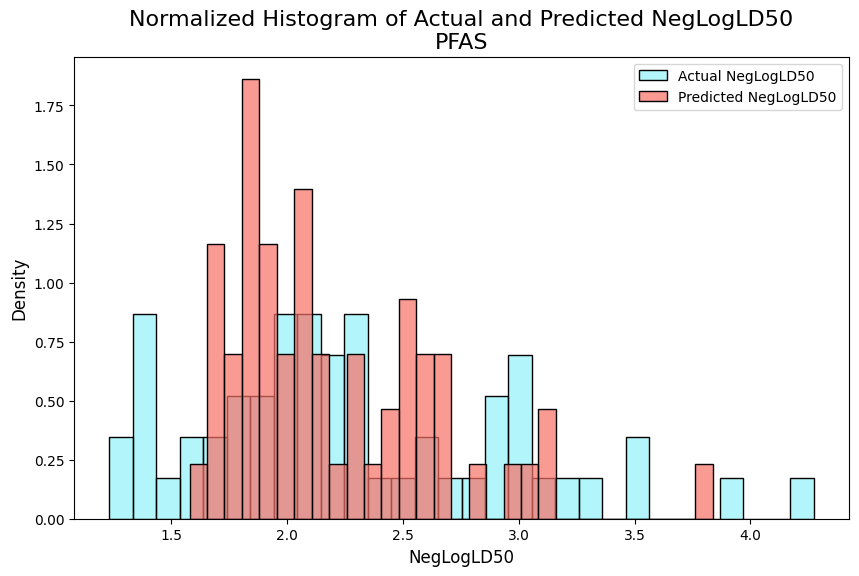

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the normalized histogram of 'actual_neglogld50'
sns.histplot(df_pfas['actual_neglogld50'], color='#66edf7', label='Actual NegLogLD50', kde=False, stat='density', alpha=0.5, bins=30)

# Plot the normalized histogram of 'prediction_neglogld50' with bars in front of 'actual_neglogld50'
sns.histplot(df_pfas['prediction_neglogld50'], color='#f77066', label='Predicted NegLogLD50', kde=False, stat='density', alpha=0.7, bins=30)

# Add labels and title
plt.title('Normalized Histogram of Actual and Predicted NegLogLD50\nPFAS', fontsize=16)
plt.xlabel('NegLogLD50', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add legend
plt.legend()

# Show the plot
plt.show()

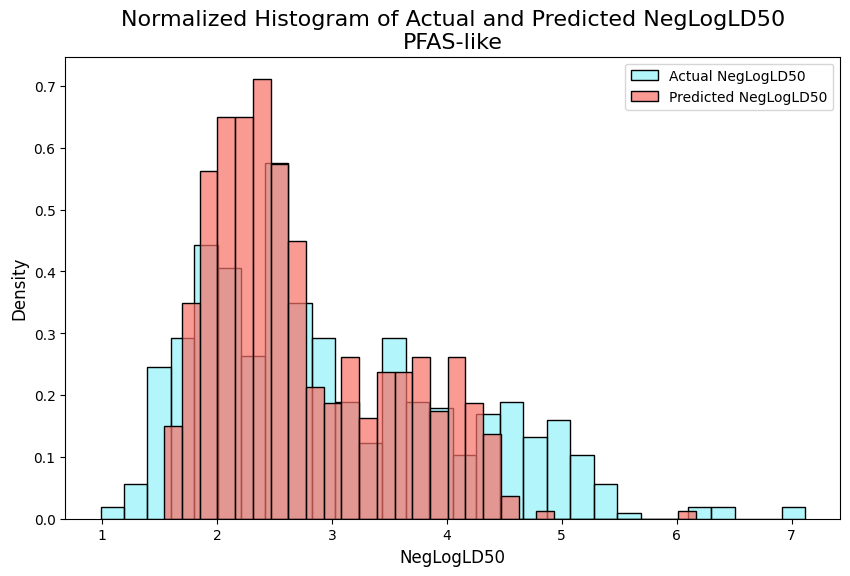

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the normalized histogram of 'actual_neglogld50'
sns.histplot(df_pfas_like['actual_neglogld50'], color='#66edf7', label='Actual NegLogLD50', kde=False, stat='density', alpha=0.5, bins=30)

# Plot the normalized histogram of 'prediction_neglogld50' with bars in front of 'actual_neglogld50'
sns.histplot(df_pfas_like['prediction_neglogld50'], color='#f77066', label='Predicted NegLogLD50', kde=False, stat='density', alpha=0.7, bins=30)

# Add labels and title
plt.title('Normalized Histogram of Actual and Predicted NegLogLD50\nPFAS-like', fontsize=16)
plt.xlabel('NegLogLD50', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add legend
plt.legend()

# Show the plot
plt.show()